In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [10]:
# Trim trailing zeros from feature sequence
def trim_zeros(features):
    reversed_features = features[::-1]
    non_zero_indices = np.where(reversed_features != 0)[0]
    if len(non_zero_indices) == 0:
        return np.array([])
    first_non_zero = non_zero_indices[0]
    end = len(features) - first_non_zero
    return features[:end]

# Load MIT-BIH dataset and process sequences
def load_mitbih(file_path):
    df = pd.read_csv(file_path, header=None)
    sequences = []
    labels = []
    
    for row in df.values:
        features = row[:-1].astype(np.float32)
        label = row[-1].astype(int)
        
        trimmed = trim_zeros(features)
        if len(trimmed) > 0:
            sequences.append(trimmed)
            labels.append(label)
    
    return sequences, labels

# Load datasets
print("Loading training data...")
train_sequences, train_labels = load_mitbih('../dataset/mitbih_train.csv')
print("Loading test data...")
test_sequences, test_labels = load_mitbih('../dataset/mitbih_test.csv')

# Number of data for each class
tmp_lables = train_labels + test_labels
unique, counts = np.unique(tmp_lables, return_counts=True)
print("Number of data of each class")
for i in range(len(unique)):
    print(f"Class {unique[i]} : {counts[i]} ({counts[i]/len(tmp_lables)*100:.2f}%)")

Loading training data...
Loading test data...
Number of data of each class
Class 0 : 90589 (82.77%)
Class 1 : 2779 (2.54%)
Class 2 : 7236 (6.61%)
Class 3 : 803 (0.73%)
Class 4 : 8039 (7.35%)


In [11]:
# Dataset class
class MITBIHDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sequence, label

# Collate function
def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences])
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    padded_sequences = padded_sequences.unsqueeze(-1)
    labels = torch.stack(labels)
    return padded_sequences, labels, lengths

# Create DataLoaders
batch_size = 128
train_dataset = MITBIHDataset(train_sequences, train_labels)
test_dataset = MITBIHDataset(test_sequences, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [12]:
# LSTM Model
class MITBIH_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x, lengths):
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        output, (hidden, _) = self.lstm(packed)
        out = self.fc(hidden[-1])
        return out

# Model initialization
num_classes = len(np.unique(train_labels))
model = MITBIH_LSTM(
    input_size=1,
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

Epoch 1/60
Train Loss: 0.6584 | Acc: 82.77%
Test Loss:  0.6576 | Acc:  82.76%

Epoch 2/60
Train Loss: 0.6486 | Acc: 82.77%
Test Loss:  0.6494 | Acc:  82.76%

Epoch 3/60
Train Loss: 0.5089 | Acc: 85.47%
Test Loss:  0.3699 | Acc:  90.36%

Epoch 4/60
Train Loss: 0.2816 | Acc: 92.33%
Test Loss:  0.2518 | Acc:  92.97%

Epoch 5/60
Train Loss: 0.2287 | Acc: 93.48%
Test Loss:  0.2330 | Acc:  93.41%

Epoch 6/60
Train Loss: 0.1885 | Acc: 94.64%
Test Loss:  0.1872 | Acc:  94.79%

Epoch 7/60
Train Loss: 0.1628 | Acc: 95.49%
Test Loss:  0.1623 | Acc:  95.55%

Epoch 8/60
Train Loss: 0.1446 | Acc: 96.02%
Test Loss:  0.1345 | Acc:  96.52%

Epoch 9/60
Train Loss: 0.1281 | Acc: 96.50%
Test Loss:  0.1418 | Acc:  96.46%

Epoch 10/60
Train Loss: 0.1163 | Acc: 96.83%
Test Loss:  0.1800 | Acc:  95.34%

Epoch 11/60
Train Loss: 0.1201 | Acc: 96.66%
Test Loss:  0.1204 | Acc:  96.85%

Epoch 12/60
Train Loss: 0.1000 | Acc: 97.21%
Test Loss:  0.1068 | Acc:  97.17%

Epoch 13/60
Train Loss: 0.0958 | Acc: 97.32%
Test

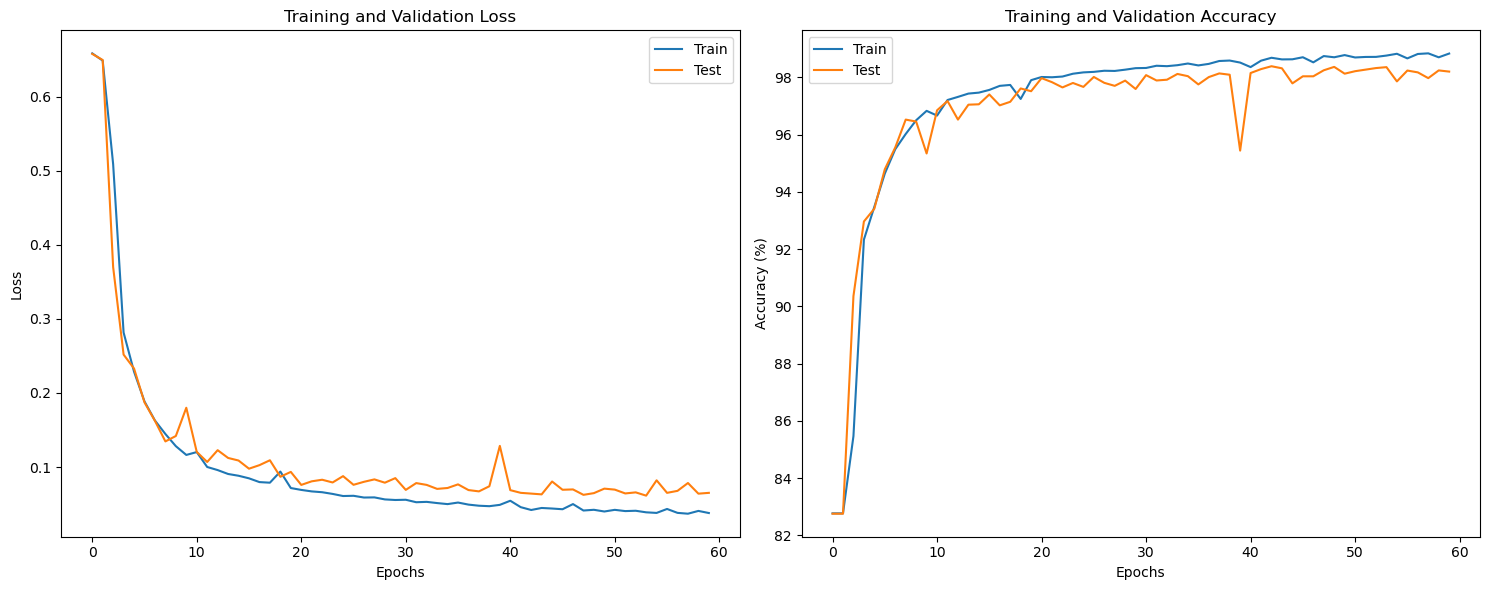

In [13]:
# Training configuration
num_epochs = 60
metrics = {
    'train_loss': [], 'test_loss': [],
    'train_acc': [], 'test_acc': []
}

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for x, y, lengths in train_loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x, lengths)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * x.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)
    
    metrics['train_loss'].append(epoch_loss / total)
    metrics['train_acc'].append(100 * correct / total)
    
    # Evaluation phase
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for x, y, lengths in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x, lengths)
            loss = criterion(outputs, y)
            
            test_loss += loss.item() * x.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_test += (predicted == y).sum().item()
            total_test += y.size(0)
    
    metrics['test_loss'].append(test_loss / total_test)
    metrics['test_acc'].append(100 * correct_test / total_test)
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {metrics["train_loss"][-1]:.4f} | Acc: {metrics["train_acc"][-1]:.2f}%')
    print(f'Test Loss:  {metrics["test_loss"][-1]:.4f} | Acc:  {metrics["test_acc"][-1]:.2f}%\n')


# Plotting
plt.figure(figsize=(15, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Train')
plt.plot(metrics['test_loss'], label='Test')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(metrics['train_acc'], label='Train')
plt.plot(metrics['test_acc'], label='Test')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Final evaluation
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for x, y, lengths in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x, lengths)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

# Classification report
class_names = ['N', 'S', 'V', 'F', 'Q']  # MIT-BIH classes: Normal, Supraventricular, Ventricular, Fusion, Unknown
report = classification_report(
    all_targets, all_preds,
    target_names=class_names,
    digits=4,
    output_dict=True
)

# Print formatted report
print("\nDetailed Classification Report:")
print(f"{'Class':<6} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
for cls in class_names:
    print(f"{cls:<6} {report[cls]['precision']:.4f}     {report[cls]['recall']:.4f}      {report[cls]['f1-score']:.4f}       {report[cls]['support']}")

print("\nWeighted Averages:")
print(f"{'Precision':<10} {report['weighted avg']['precision']:.4f}")
print(f"{'Recall':<10} {report['weighted avg']['recall']:.4f}")
print(f"{'F1-Score':<10} {report['weighted avg']['f1-score']:.4f}")


Detailed Classification Report:
Class  Precision  Recall     F1-Score   Support   
N      0.9856     0.9964      0.9910       18118.0
S      0.9145     0.7122      0.8008       556.0
V      0.9545     0.9420      0.9482       1448.0
F      0.8333     0.6790      0.7483       162.0
Q      0.9956     0.9801      0.9878       1608.0

Weighted Averages:
Precision  0.9814
Recall     0.9820
F1-Score   0.9813


In [15]:
# Save the model in directory model
torch.save(model.state_dict(), '../model/lstm_model2.pth')
print('Model saved successfully!')

Model saved successfully!
